In [1]:
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable


In [2]:
from pyspark.mllib.regression import LabeledPoint
import numpy as np
from pyspark.sql import Row
from pyspark.sql import functions as sql_functions
from pyspark.sql.types import *

In [3]:
def getDF(file_name):  # File location and 
  file_location = file_name
  file_type = "csv"

  # CSV options
  infer_schema = "true"                            #automatically takes column types as double and label as int
  first_row_is_header = "false"
  delimiter = ","

  # The applied options are for CSV files. For other file types, these will be ignored.
  df = spark.read.format(file_type) \
    .option("inferSchema", infer_schema) \
    .option("header", first_row_is_header) \
    .option("sep", delimiter) \
    .load(file_location)
  table_name = 'table'
  df.createOrReplaceTempView(table_name)    #for permanent : -> df.write.format(parquet).saveastable.....
  
  df = sqlContext.sql("Select * from "+table_name)   #load dataframe from table
  return df

In [4]:
def parse_points(df):
    new_df = df.rdd.map(lambda row: LabeledPoint(row[0], [x for x in row[1:]])) \
                   .toDF(['features', 'label'])                        #label and features are available as class variables of Labldpnt..
    return new_df

In [5]:
raw_data_df = getDF('YearPredictionMSD.txt')

22/05/08 22:29:08 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [6]:
parsed_points_df = parse_points(raw_data_df)
parsed_points_df.show(2)

+--------------------+------+
|            features| label|
+--------------------+------+
|[49.94357,21.4711...|2001.0|
|[48.73215,18.4293...|2001.0|
+--------------------+------+
only showing top 2 rows



In [7]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [8]:
def prepare_plot(xticks, yticks, figsize=(10.5, 6), hideLabels=False, gridColor='#999999',
                 gridWidth=1.0):
    """Template for generating the plot layout."""
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hideLabels: axis.set_ticklabels([])
    plt.grid(color=gridColor, linewidth=gridWidth, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
    return fig, ax

Minimum year: 1922
Maximum year: 2011


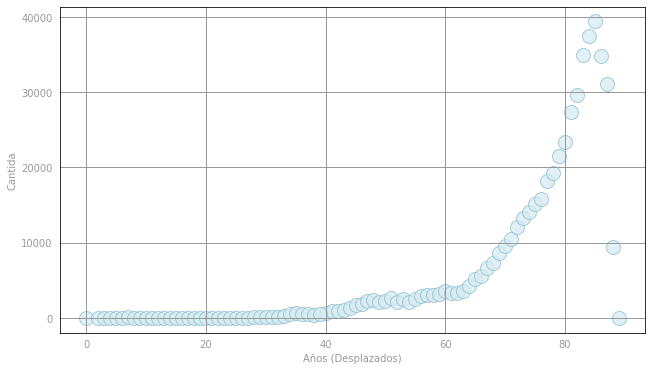

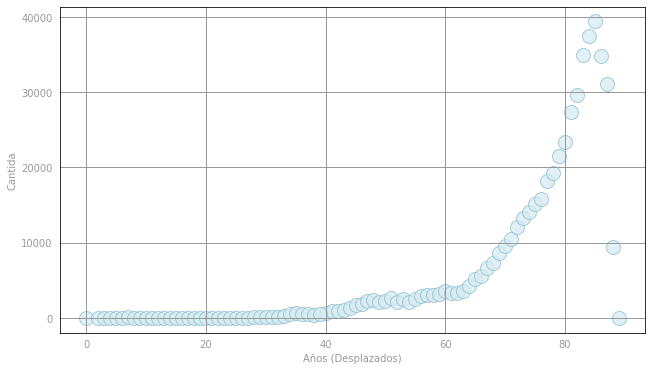

In [9]:
content_stats = (parsed_points_df
                 .selectExpr("min(label)", "max(label)").rdd.flatMap(list).collect())

min_year = content_stats[0]
max_year = content_stats[1]
print('Minimum year: {0}'.format(int(min_year)))
print('Maximum year: {0}'.format(int(max_year)))
parsed_data_df = parsed_points_df.select(parsed_points_df['label']-min_year , 'features').withColumnRenamed('(label - 1922.0)','label')
newData = (parsed_data_df
           .rdd.map(lambda lp: (lp.label, 1))    #mapreduce
           .reduceByKey(lambda x, y: x + y)
           .collect())   #array
x, y = zip(*newData)

# generate layout and plot data
fig, ax = prepare_plot(np.arange(0, 120, 20), np.arange(0, 50000, 10000))
plt.scatter(x, y, s=14**2, c='#d6ebf2', edgecolors='#8cbfd0', alpha=0.75)
ax.set_xlabel('Años (Desplazados)'), ax.set_ylabel('Cantida')
display(fig)

In [10]:
parsed_data_df.show(15)

+-----+--------------------+
|label|            features|
+-----+--------------------+
| 79.0|[49.94357,21.4711...|
| 79.0|[48.73215,18.4293...|
| 79.0|[50.95714,31.8560...|
| 79.0|[48.2475,-1.89837...|
| 79.0|[50.9702,42.20998...|
| 79.0|[50.54767,0.31568...|
| 79.0|[50.57546,33.1784...|
| 79.0|[48.26892,8.97526...|
| 79.0|[49.75468,33.9958...|
| 85.0|[45.17809,46.3423...|
| 86.0|[39.13076,-23.017...|
| 80.0|[37.66498,-34.059...|
| 82.0|[26.51957,-148.15...|
| 81.0|[37.68491,-26.841...|
| 77.0|[39.11695,-8.2976...|
+-----+--------------------+
only showing top 15 rows



In [11]:
weights = [.8, .1, .1]
seed = 5
parsed_train_data_df, parsed_val_data_df, parsed_test_data_df = parsed_data_df.randomSplit(weights, seed= seed)
parsed_train_data_df.cache()
parsed_val_data_df.cache()
parsed_test_data_df.cache()
n_train = parsed_train_data_df.count()
n_val = parsed_val_data_df.count()
n_test = parsed_test_data_df.count()
average_train_year = (parsed_train_data_df
                        .selectExpr('avg(label)').first())
print('Average year: {0}'.format(average_train_year['avg(label)']))

Average year: 76.40243429064955


In [12]:
print(n_train)

412194


In [13]:
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.cm import get_cmap
cmap = get_cmap('YlOrRd')
norm = Normalize()

In [14]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(predictionCol = 'prediction')
def calc_RMSE(dataset):
    return evaluator.evaluate(dataset)

In [15]:
from pyspark.mllib.linalg import DenseVector

def gradient_summand(weights, lp):
    """Calculates the gradient summand for a given weight and `LabeledPoint`.
    
    Args:
        weights (DenseVector): An array of model weights (betas).
        lp (LabeledPoint): The `LabeledPoint` for a single observation.

    Returns:
        DenseVector: An array of values the same length as `weights`.  The gradient summand.
    """
    return(np.dot(np.dot(weights.T, lp.features)-lp.label, lp.features)) 
def get_labeled_prediction(weights, observation):
    """Calculates predictions and returns a (prediction, label) tuple.

    Args:
        weights (np.ndarray): An array with one weight for each features in `trainData`.
        observation (LabeledPoint): A `LabeledPoint` that contain the correct label and the
            features for the data point.

    Returns:
        tuple: A (prediction, label) tuple. Convert the return type of the label and prediction to a float.
    """
    return( (float(np.dot(weights.T, observation.features)), float(observation.label)) )

In [16]:
def linreg_gradient_descent(train_data, num_iters):
    """Calculates the weights and error for a linear regression model trained with gradient descent.

    Args:
        train_data (RDD of LabeledPoint): The labeled data for use in training the model.
        num_iters (int): The number of iterations of gradient descent to perform.

    Returns:
        (np.ndarray, np.ndarray): A tuple of (weights, training errors).  Weights will be the
            final weights (one weight per feature) for the model, and training errors will contain
            an error (RMSE) for each iteration of the algorithm.
    """
    
    # The length of the training data
    n = train_data.count()
    
    # The number of features in the training data
    d = len(train_data.first().features)
    w = np.zeros(d)
    alpha = 0.000025
    
    # We will compute and store the training error after each iteration
    error_train = np.zeros(num_iters)
    for i in range(num_iters):
        preds_and_labels_train = train_data.rdd.map(lambda row: get_labeled_prediction(w, row))
        preds_and_labels_train_df = sqlContext.createDataFrame(preds_and_labels_train, ["prediction", "label"])
        error_train[i] = calc_RMSE(preds_and_labels_train_df)

        gradient = train_data.rdd.map(lambda row: gradient_summand(w, row)).sum()

        # Update the weights
        
        w -= alpha*gradient
    preds_and_labels_train_df.show(15)
    print(gradient,n)
    return w, error_train

In [17]:
print(type(average_train_year))

<class 'pyspark.sql.types.Row'>


In [18]:
#Baseline errors => shows almost equal distribution of classes around average
preds_and_labels_train = parsed_train_data_df.rdd.map(lambda row: (average_train_year['avg(label)'], int(row['label'])))
preds_and_labels_train_df = sqlContext.createDataFrame(preds_and_labels_train, ["prediction", "label"])
rmse_train_base = calc_RMSE(preds_and_labels_train_df)

preds_and_labels_val = parsed_val_data_df.rdd.map(lambda row: (average_train_year['avg(label)'], int(row['label'])))
preds_and_labels_val_df = sqlContext.createDataFrame(preds_and_labels_val, ["prediction", "label"])
rmse_val_base = calc_RMSE(preds_and_labels_val_df)

preds_and_labels_test = parsed_test_data_df.rdd.map(lambda row: (average_train_year['avg(label)'], int(row['label'])))
preds_and_labels_test_df = sqlContext.createDataFrame(preds_and_labels_test, ["prediction", "label"])
rmse_test_base = calc_RMSE(preds_and_labels_test_df)

print('Baseline Train RMSE = {0:.3f}'.format(rmse_train_base))
print('Baseline Validation RMSE = {0:.3f}'.format(rmse_val_base))
print('Baseline Test RMSE = {0:.3f}'.format(rmse_test_base))

Baseline Train RMSE = 10.931
Baseline Validation RMSE = 10.951
Baseline Test RMSE = 10.915


In [19]:
parsed_train_data_df.show(15)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  4.0|[27.59278,-179.29...|
|  5.0|[32.05226,-212.58...|
|  5.0|[32.80382,-165.04...|
|  8.0|[20.82134,-105.06...|
|  8.0|[35.55615,-56.582...|
|  8.0|[35.57837,-73.831...|
| 11.0|[35.52117,-173.08...|
| 19.0|[30.25882,-62.391...|
| 19.0|[31.02982,-74.326...|
| 19.0|[31.96273,-101.69...|
| 19.0|[34.57043,-169.65...|
| 19.0|[39.21391,-135.56...|
| 20.0|[37.40434,-170.76...|
| 21.0|[30.21388,-75.802...|
| 23.0|[33.40615,-134.76...|
+-----+--------------------+
only showing top 15 rows



In [20]:
num_iters = 25
weights_LR0, error_train_LR0 = linreg_gradient_descent(parsed_train_data_df, num_iters)

parsed_val_data_df.show(5)
preds_and_labels = (parsed_val_data_df
                      .rdd.map(lambda row: get_labeled_prediction(weights_LR0, row) ))


print('Validation RMSE:\n\tBaseline = {0:.3f}\n\tLR0 = '.format(rmse_val_base))

+--------------------+-----+
|          prediction|label|
+--------------------+-----+
|-1.14500106146127...|  4.0|
|-9.83940255986983...|  5.0|
|-8.83462328152700...|  5.0|
|-2.21169916686237...|  8.0|
|-1.07349910451345...|  8.0|
|-1.18527295506816...|  8.0|
|-8.35090150013185...| 11.0|
|-1.32303653604033...| 19.0|
|-1.34826711569093...| 19.0|
|-1.57192011453634...| 19.0|
|-7.74247953754221...| 19.0|
|-7.15594536224314...| 19.0|
|-8.49283951000331...| 20.0|
|-1.71911879554550...| 21.0|
|-8.43966917460579...| 23.0|
+--------------------+-----+
only showing top 15 rows

[-1.37826773e+208  1.87564200e+207 -1.00778401e+207 -1.25305834e+207
  9.99665890e+206  2.35053836e+207  8.48457839e+206  4.66949369e+206
 -9.53590865e+206 -6.47178146e+206  1.16198899e+206 -9.24878727e+206
 -1.29349434e+208 -1.07909367e+210 -8.29861431e+209 -6.42330596e+209
 -3.53632901e+209 -3.55219642e+209 -2.34779537e+209 -2.08116907e+209
 -1.50691478e+209 -1.26707596e+209 -1.16496535e+209 -1.08890926e+209
 -1.71537

In [21]:
print(preds_and_labels.take(15))

[(2.002846331799608e+209, 34.0), (2.190824355197353e+209, 35.0), (1.7012456948616837e+209, 38.0), (2.0317757325342087e+209, 38.0), (2.5035154045643358e+209, 39.0), (1.5896324936585929e+209, 41.0), (1.568829700189763e+209, 41.0), (1.7898805795240577e+209, 42.0), (2.3080542501268054e+209, 43.0), (1.2695307936968098e+209, 43.0), (1.558574420734812e+209, 44.0), (1.338423400168171e+209, 44.0), (1.3974693264965865e+209, 44.0), (2.3168669223298593e+209, 45.0), (1.7980781821281283e+209, 45.0)]


In [22]:
preds_and_labels_df = sqlContext.createDataFrame(preds_and_labels, ["prediction", "label"])

preds_and_labels_df.show(5)
rmse_val_LR0 = calc_RMSE(preds_and_labels_df)
print(rmse_val_LR0)

+--------------------+-----+
|          prediction|label|
+--------------------+-----+
|2.002846331799608...| 34.0|
|2.190824355197353...| 35.0|
|1.701245694861683...| 38.0|
|2.031775732534208...| 38.0|
|2.503515404564335...| 39.0|
+--------------------+-----+
only showing top 5 rows

inf


In [23]:
type(rmse_val_LR0)

float

/LUSTRE/home/jleyva/.local/lib/python3.8/site-packages/matplotlib/colors.py:1254: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)


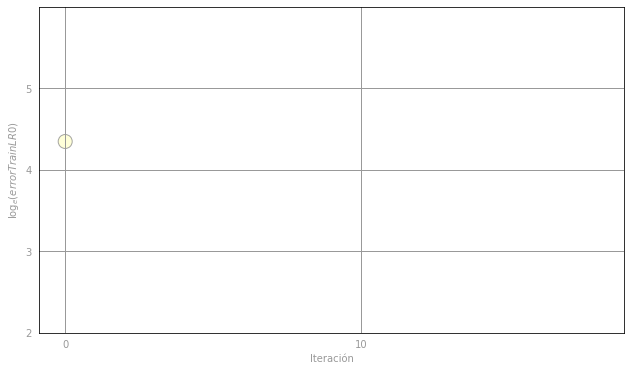

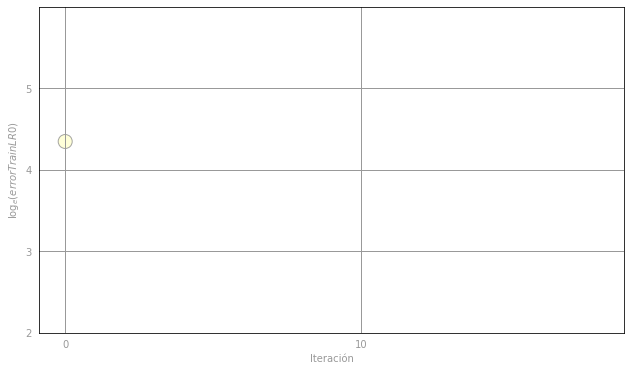

In [24]:
norm = Normalize()
clrs = cmap(np.asarray(norm(np.log(error_train_LR0))))[:,0:3]

fig, ax = prepare_plot(np.arange(0, 60, 10), np.arange(2, 6, 1))
ax.set_ylim(2, 6)
plt.scatter(range(0, num_iters), np.log(error_train_LR0), s=14**2, c=clrs, edgecolors='#888888', alpha=0.75)
ax.set_xlabel('Iteración'), ax.set_ylabel(r'$\log_e(errorTrainLR0)$')
display(fig)

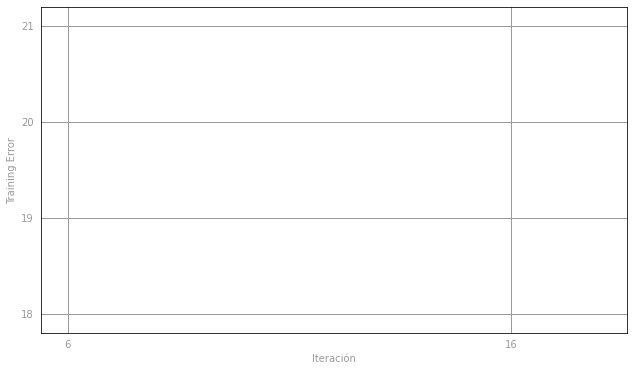

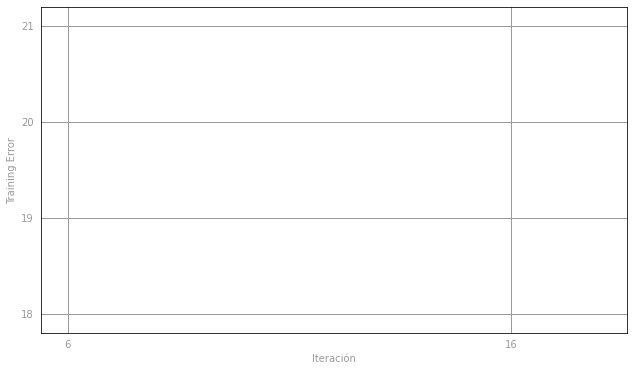

In [25]:
norm = Normalize()
clrs = cmap(np.asarray(norm(error_train_LR0[6:])))[:,0:3]

fig, ax = prepare_plot(np.arange(0, 60, 10), np.arange(17, 22, 1))
ax.set_ylim(17.8, 21.2)
plt.scatter(range(0, num_iters-6), error_train_LR0[6:], s=14**2, c=clrs, edgecolors='#888888', alpha=0.75)
ax.set_xticklabels(map(str, range(6, 66, 10)))
ax.set_xlabel('Iteración'), ax.set_ylabel(r'Training Error')
display(fig)

In [26]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.linalg import Vectors, VectorUDT
# Values to use when training the linear regression model

num_iters = 500  # iterations
reg = 1e-1  # regParam
alpha = .2  # elasticNetParam
use_intercept = True  # intercept

parsed_train_data_df = parsed_train_data_df.withColumn("label", parsed_train_data_df["label"].cast(DoubleType()))
parsed_train_data_rdd = parsed_train_data_df.rdd.map(lambda row : (row.label, Vectors.dense([float(x) for x in row.features ])))
parsed_train_data_df = sqlContext.createDataFrame(parsed_train_data_rdd, ["label","features"])
lin_reg = LinearRegression(maxIter = num_iters, regParam = reg, elasticNetParam = alpha, fitIntercept = use_intercept, labelCol = 'label', featuresCol = 'features')
first_model = lin_reg.fit(parsed_train_data_df)

# coeffsLR1 stores the model coefficients; interceptLR1 stores the model intercept
coeffs_LR1 = first_model.coefficients
intercept_LR1 = first_model.intercept
print (coeffs_LR1, intercept_LR1)

[0.8352892733369766,-0.0519071382748952,-0.042108620468641965,-0.0026892687530811477,-0.010473857622112972,-0.20443175013094148,0.0,-0.08345274094559098,-0.05900737776202518,0.01699323384468839,-0.1271704227687262,-0.007423074932169715,0.042038248790405235,0.0003588738411781226,-0.0003675574035878728,0.0005521565145351686,0.00045722731370480984,0.0012016705560044705,0.0018483886831268208,0.0021047122308711316,0.0006754647865795002,0.0,0.0070018426082589895,0.002465283951551077,-0.002781316525165297,2.018531885336287e-05,0.001426519033796339,0.00036010360331140644,0.0007118617349864704,-0.00014239314840622805,-0.0012396456527578204,-0.0008494851841339401,-0.005144592229906038,0.0019448379310113655,0.00051362952327639,-0.004762472494352917,-0.00014302183863104992,0.0007317219215071123,0.0013269435551727079,-0.001573090104696363,-0.002424452169035746,-0.0006570006425264745,-0.0009689511476874545,-0.0016119140492957197,-0.002770295052569792,0.00480760954774618,0.0004328642322046271,-0.0017

In [27]:
sample_prediction = first_model.transform(parsed_train_data_df)
display(sample_prediction)

DataFrame[label: double, features: vector, prediction: double]

In [28]:
sample_prediction.take(19)

[Row(label=4.0, features=DenseVector([27.5928, -179.299, -12.6056, -28.0885, -10.3794, 11.6987, 0.5783, 18.7222, -27.635, 17.0994, -13.8579, -10.4754, 16.8408, 2706.6961, 3950.7837, 1840.7693, 2073.1295, 1182.0459, 430.1077, 618.8313, 528.2529, 447.6573, 460.4904, 284.6452, -22.1422, 1829.81, 423.162, -678.9253, -311.895, 55.5352, -75.9793, 31.4177, -56.4805, -103.3851, -56.9188, 150.8384, 272.8705, -1895.8368, -212.7489, 288.2319, -192.0076, -124.4517, -57.9057, 2.0496, 23.2045, 68.1824, -1271.7197, 721.89, -436.606, 257.7871, -64.5592, 113.1978, -14.9687, -19.8262, -124.8876, 499.5827, -142.2496, 476.4827, -372.104, 376.0891, 66.3229, 25.3947, 20.8642, -84.3546, -739.4589, 259.2715, 287.5407, -271.3356, 36.0947, -27.9376, -314.4529, 234.7121, -284.3928, 12.6855, -33.7634, -18.5151, 217.2082, -324.575, -278.7042, 123.2973, 39.0197, -70.492, 149.3804, 62.7639, -21.3715, -45.1013, -235.4759, 0.0098, 22.1165, -11.9866]), prediction=74.42022447726873),
 Row(label=5.0, features=DenseVector

In [29]:
parsed_val_data_df = parsed_val_data_df.withColumn("label", parsed_val_data_df["label"].cast(DoubleType()))
parsed_val_data_rdd = parsed_train_data_df.rdd.map(lambda row : (row.label, Vectors.dense([float(x) for x in row.features ])))
parsed_val_data_df = sqlContext.createDataFrame(parsed_val_data_rdd, ["label","features"])
val_pred_df = first_model.transform(parsed_val_data_df)
rmse_val_LR1 = calc_RMSE(val_pred_df)

print (('Validation RMSE:\n\tBaseline = {0:.3f}\n\tLR0 = {1:.3f}' +
       '\n\tLR1 = {2:.3f}').format(rmse_val_base, rmse_val_LR0, rmse_val_LR1))

Validation RMSE:
	Baseline = 10.951
	LR0 = inf
	LR1 = 9.548
